## Leitura de todas as abas da planilha

In [135]:
from IPython.display import Markdown, display
import pandas as pd
import datetime
from calendar import monthrange


# Definicao dos nomes das abas
months = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']
years = ['17', '18', '19' ]
month_year = [m+y for y in years for m in months]

# Quantidade de dias no mês
month_len = [monthrange(2000 + int(y), m + 1)[1] for y in years for m in range(len(months))]

# Definição do tipo data para a variável mês (utiliza-se o último dia do mês como referência)
dates = [datetime.datetime(2000 + int(y), m + 1, monthrange(2000 + int(y), m + 1)[1]) 
         for y in years for m in range(len(months))]


# Funcao para ler uma aba
def read_sheet(sheet_name):
    try:
        df = pd.read_excel("cases_internacao_SUS.xls", sheet_name=sheet_name)
        df['Mês/Ano'] = sheet_name
        df['Data'] = [dates[i] for i,x in enumerate(month_year) if x == sheet_name][0]
        df['Dias no mês'] = [month_len[i] for i,x in enumerate(month_year) if x == sheet_name][0]
        return df
    except:
        return None

# Leitura de todas as abas: um DataFrame por aba
sheets = [read_sheet(sheet_name) for sheet_name in month_year]

# Concatenacao dos DataFrames
cases_df = pd.concat([s for s in sheets if s is not None]).reset_index(drop=True)

# Remocao das linhas nulas e os totais de cada aba
ft1 = cases_df.iloc[:,0].notnull()
ft2 = cases_df.iloc[:,0] != ' '
ft3 = cases_df.iloc[:,0] != 'Total'

cases_df = cases_df[ft1 & ft2 & ft3].reset_index(drop=True)

# Transformacao das colunas de formato numerico para string
for c in [c for c in cases_df.columns if 'Val_' == c[:4]]:
    cases_df[c] = cases_df[c].map(lambda x: None if x == '-' else float(x))

display(Markdown("#### Colunas do DataFrame:"))
for c in cases_df.columns: print("  -",c)

#### Colunas do DataFrame:

  - Região/Unidade da Federação
  - Internações
  - AIH_aprovadas
  - Valor_total
  - Valor_serviços_hospitalares
  - Val_serv_hosp_-_compl_federal
  - Val_serv_hosp_-_compl_gestor
  - Valor_serviços_profissionais
  - Val_serv_prof_-_compl_federal
  - Val_serv_prof_-_compl_gestor
  - Valor_médio_AIH
  - Valor_médio_intern
  - Dias_permanência
  - Média_permanência
  - Óbitos
  - Taxa_mortalidade
  - Mês/Ano
  - Data
  - Dias no mês


## Visualização dos meses faltantes

Apenas os meses de abril, julho e dezembro possuem dados em mais de um ano. Além disto, nenhum dos anos está completo, o que dificulta bastante entender a tendência e a sazonalidade dos dados.

In [136]:
filled_months = cases_df["Mês/Ano"].unique()

data = {"20%s"%year:["Sim" if "%s%s"%(month, year) in filled_months else "" for month in months] for year in years}

pd.DataFrame(data, index=months).T

,jan,fev,mar,abr,mai,jun,jul,ago,set,out,nov,dez
2017,,,,,,,,,,,,Sim
2018,,,Sim,Sim,Sim,,Sim,Sim,Sim,,Sim,Sim
2019,Sim,Sim,,Sim,,Sim,Sim,,,,,


# Visualização das variáveis por região

## Internações

Para realizar esta visualização as variáveis serão modificadas para uma taxa diária. O motivo desta abordagem é que espera-se que em meses com mais dias, ocorram mais internações, portanto a quantidade de dias no mês pode ser um fator importante para explicar algumas flutuações nos dados.

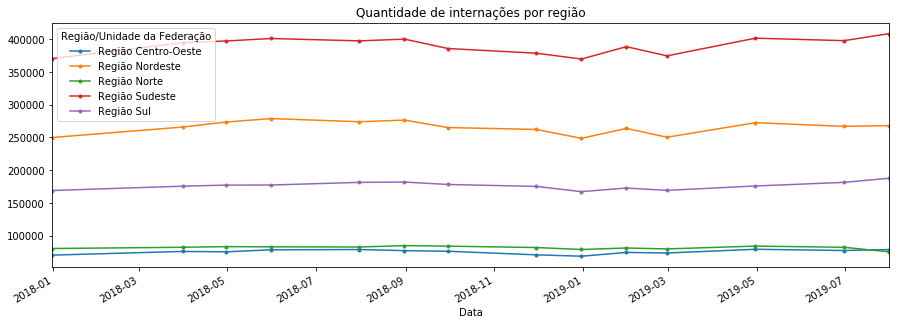

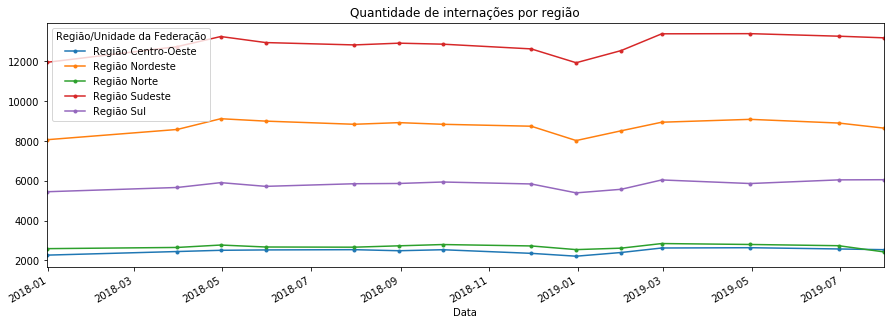

In [25]:
%matplotlib inline

cases_df["Internações - taxa diária"] = cases_df.apply(lambda x: x["Internações"] / x["Dias no mês"], axis=1)
ft = cases_df["Região/Unidade da Federação"].map(lambda x: x[:6] == "Região")

ax = pd.pivot_table(cases_df[ft], values="Internações", index="Data", columns="Região/Unidade da Federação")\
       .plot(figsize=(15,5), title="Quantidade de internações por região", style='.-')

ax = pd.pivot_table(cases_df[ft], values="Internações - taxa diária", index="Data", columns="Região/Unidade da Federação")\
       .plot(figsize=(15,5), title="Quantidade de internações por região", style='.-')

#### Análise das internações

A normalização pela quantidade de dias revelou uma aparente estabilidade nos meses de jun/18 até dez/18, com uma queda no mês de jan/19 seguida de um aumento nos meses de fev/19, mar/19 e abr/19. A quantidade de internações baixa em jan/18 seguida de um aumento em abr/18 sugere a mesma tendência neste período do ano. No entanto é não há como comprovar se trata-se de um evento sazonal ou pontual devido ao histórico pequeno de dados. 

## Óbitos

A quantidade de óbitos quando comparada à quantidade de internações pode nos dizer um pouco sobre a qualidade dos hospitais. Em condições igualitárias é esperado que a distribuição dos óbitos seja semelhante à distribuição das internações.

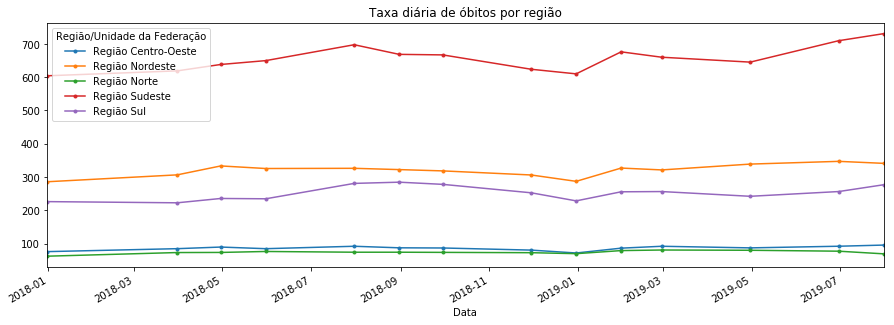

In [29]:
%matplotlib inline

cases_df["Óbitos - taxa diária"] = cases_df.apply(lambda x: x["Óbitos"] / x["Dias no mês"], axis=1)

ax = pd.pivot_table(cases_df[ft], values="Óbitos - taxa diária", index="Data", columns="Região/Unidade da Federação")\
       .plot(figsize=(15,5), title="Taxa diária de óbitos por região", style='.-')

#### Análise da mortalidade

Visualmente é possível observar um indício de sazonalidade nos dados, com um aumento no período de inverno e um queda no verão. Isto fica mais acentuado nas regiões sul e sudeste, onde existe maior variação climática neste período. Por outro lado isto não fica muito claro nas outras regiões. Possivelmente o clima pode ter uma relação com a quantidade de óbitos.

Ainda existe uma queda clara no mesde janeiro seguida de um aumento em fevereiro.

Estes indícios são reafirmados pela variável taxa de mortalidade no gráfico abaixo.

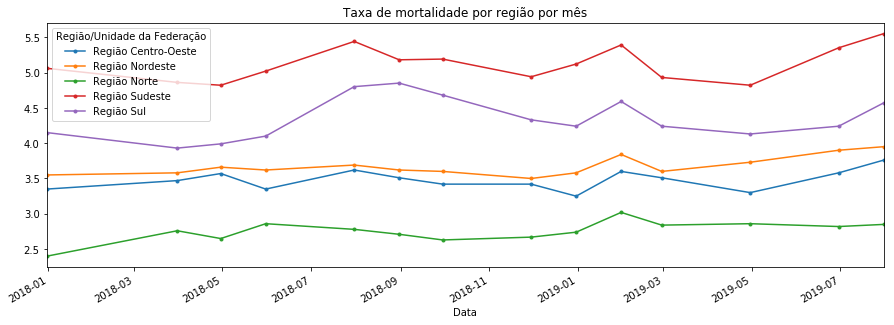

In [31]:
ax = pd.pivot_table(cases_df[ft], values="Taxa_mortalidade", index="Data", columns="Região/Unidade da Federação")\
       .plot(figsize=(15,5), title="Taxa de mortalidade por região por mês", style='.-')

# Estimação de valores faltantes

## Método 1 - Interpolação linear

Uma vez que as variáveis possuem variações pequenas e não há como usar outras variáveis para explicar os dados faltantes no mês onde não há registro, a interpolação pode ser uma maneira simples e efetiva para estimar estes valores. 

A ideia seria reproduzir em valores numéricos o que foi apresentado nos gráficos. Ou seja dados dois pontos no gráfico, um ponto intermediário pode ser adicionado exatamente onde a reta entre os pontos está passando. Este ponto (x, y) pode ser calculado pela fórmula abaixo:

$$ y = y_0 + (y_1 - y_0)\frac{x - x_0}{x_1 - x_0} $$

Para nosso caso específico os valores de $x$ serão calculados em dias. Isto faz bastante sentido para as variáveis "Internações" e "Óbitos". Outro ponto importante a se considerar é o fato de os valores regionais serem apenas uma agregação dos valores estaduais, portanto eles podem ser estimados a partir dos valores dos estados.

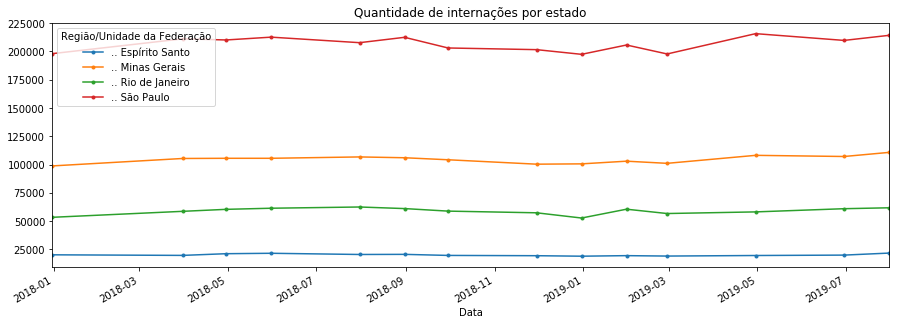

In [160]:
sudeste = ['.. Minas Gerais', '.. Espírito Santo', '.. Rio de Janeiro', '.. São Paulo']
ft = cases_df["Região/Unidade da Federação"].map(lambda x: x in sudeste)

ax = pd.pivot_table(cases_df[ft], values="Internações", index="Data", columns="Região/Unidade da Federação")\
       .plot(figsize=(15,5), title="Quantidade de internações por estado", style='.-')

In [164]:
import numpy as np

mask = np.array([my not in filled_months for my in month_year[11:-5]])

estemated_df = pd.DataFrame({"Mês/Ano":np.array(month_year[11:-5])[mask],
                             "Data":np.array(dates[11:-5])[mask], 
                             "Dias no mês":np.array(month_len[11:-5])[mask]})

filled_df = cases_df.iloc[:,-3:].drop_duplicates().reset_index(drop=True)

def get_edges(date):
    
    distances = abs(filled_df.Data - date).sort_values()
    neighbours = filled_df.iloc[distances[:2].index, :]
    
    return neighbours


def estimate_value(col_name, date, state):
    
    neigh_df = get_edges(date)

    ft1 = cases_df["Região/Unidade da Federação"] == state
    ft2 = cases_df["Data"].map(lambda x: x in neigh_df.Data.tolist())

    [[y0, x0],[y1, x1]] = cases_df[ft1 & ft2][[col_name, "Data"]].sort_values("Data").apply(list, axis=1).tolist()
    
    y = y0 + (y1 - y0)*((date - x0)/(x1 - x0))

    return y

In [165]:
estimations = {"Internações":[], "Mês/Ano":[], "Data":[], "Dias no mês":[], "Região/Unidade da Federação":[], "Óbitos":[]}

for state in sudeste:
    for m, d, ml in estemated_df.apply(tuple, axis=1):
        estimations["Região/Unidade da Federação"].append(state)
        estimations["Mês/Ano"].append(m)
        estimations["Data"].append(d)
        estimations["Dias no mês"].append(ml)
        estimations["Internações"].append(estimate_value("Internações", date, state))
        estimations["Óbitos"].append(estimate_value("Óbitos", date, state))

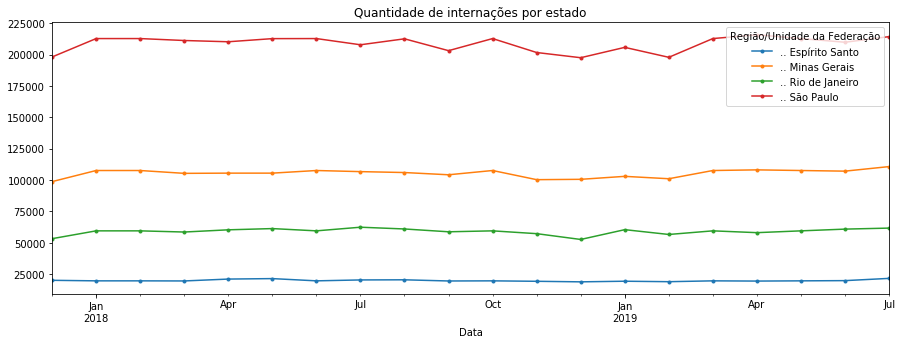

In [166]:
new_dataset = pd.concat((cases_df[ft], pd.DataFrame(estimations)), sort=False).sort_values("Data").reset_index(drop=True)

ax = pd.pivot_table(new_dataset, values="Internações", index="Data", columns="Região/Unidade da Federação")\
       .plot(figsize=(15,5), title="Quantidade de internações por estado", style='.-')

In [167]:
new_dataset[new_dataset["Região/Unidade da Federação"] == sudeste[0]]

,Região/Unidade da Federação,Internações,AIH_aprovadas,Valor_total,Valor_serviços_hospitalares,Val_serv_hosp_-_compl_federal,Val_serv_hosp_-_compl_gestor,Valor_serviços_profissionais,Val_serv_prof_-_compl_federal,Val_serv_prof_-_compl_gestor,Valor_médio_AIH,Valor_médio_intern,Dias_permanência,Média_permanência,Óbitos,Taxa_mortalidade,Mês/Ano,Data,Dias no mês
0,.. Minas Gerais,98755.000000,99588.0,1.428486e+08,1.143035e+08,858086.85,81908.34,26803605.72,81908.34,191177.96,1434.40,1446.49,501519.0,5.1,4573.000000,4.63,dez17,2017-12-31,31
7,.. Minas Gerais,107604.622951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4909.557377,NaN,jan18,2018-01-31,31
8,.. Minas Gerais,107604.622951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4909.557377,NaN,fev18,2018-02-28,28
14,.. Minas Gerais,105344.000000,106139.0,1.498300e+08,1.198770e+08,681639.80,77636.86,28537383.86,77636.86,156307.99,1411.64,1422.29,533778.0,5.1,4638.000000,4.40,mar18,2018-03-31,31
19,.. Minas Gerais,105513.000000,106274.0,1.498945e+08,1.203657e+08,644423.47,99672.88,28183114.18,99672.88,141217.23,1410.45,1420.63,534974.0,5.1,4746.000000,4.50,abr18,2018-04-30,30
22,.. Minas Gerais,105513.000000,106289.0,1.515469e+08,1.218227e+08,679719.54,98585.15,28320161.39,98585.15,156012.16,1425.80,1436.29,541701.0,5.1,4751.000000,4.50,mai18,2018-05-31,31
27,.. Minas Gerais,107604.622951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4909.557377,NaN,jun18,2018-06-30,30
31,.. Minas Gerais,106719.000000,107468.0,1.566802e+08,1.260695e+08,790638.18,79073.57,29069448.39,79073.57,138475.15,1457.92,1468.16,553916.0,5.2,4977.000000,4.66,jul18,2018-07-31,31
34,.. Minas Gerais,105993.000000,106723.0,1.542815e+08,1.243958e+08,551787.59,82504.24,28730687.83,82504.24,130135.32,1445.63,1455.58,547279.0,5.2,5004.000000,4.72,ago18,2018-08-31,31
39,.. Minas Gerais,104207.000000,104937.0,1.538679e+08,1.236119e+08,801921.92,78453.26,28672407.12,78453.26,168169.24,1466.29,1476.56,536576.0,5.1,4905.000000,4.71,set18,2018-09-30,30
